In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import seaborn as sns
import corner as corner

In [2]:
%matplotlib notebook
Colour = plt.style.use('tableau-colorblind10')

In [3]:
def Ensure_all(All_variables):
    no_nan_tables = [table.dropna() for table in All_variables]
    
    num_variables = len(no_nan_tables)
    previous_merge = no_nan_tables[0]
    for index in range(1, num_variables):
        current_table = no_nan_tables[index]
        previous_merge = pd.merge(previous_merge, current_table, left_index=True, right_index=True, how='inner')
    return previous_merge

<IPython.core.display.Javascript object>


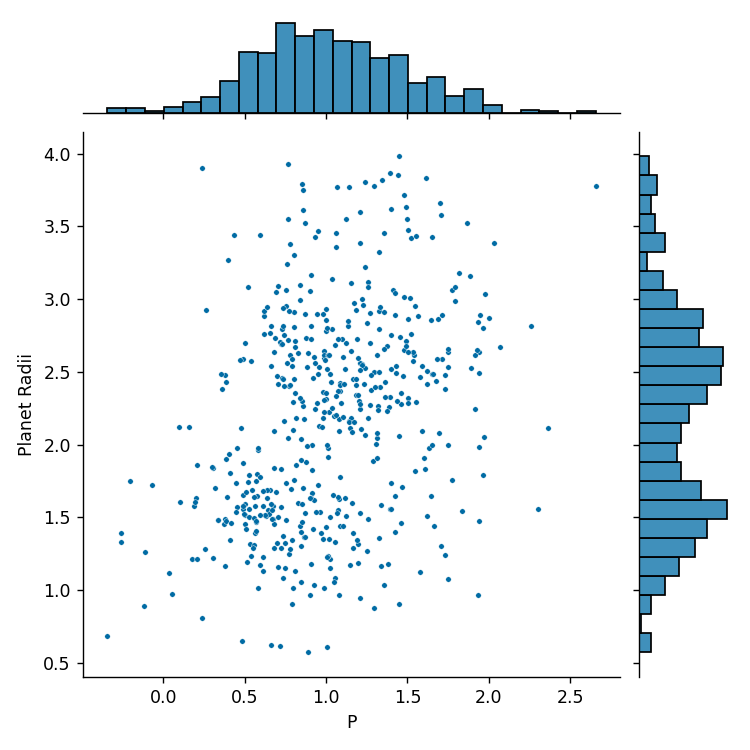

In [4]:
Main_directory = 'C:/Users/Iwan/Documents/GitHub/Iwan-and-George-Year-4-Project'
BASTA_stars = pd.read_csv(f'{Main_directory}/BASTA/Output/GaiaResultsFinal.ascii', index_col='starid' ,sep='\t').dropna()
Planet_data = pd.read_csv(f'{Main_directory}/Samples/Sorted Data/Planets/Final Planets.csv'
                          , index_col='KOI').dropna()

Planet_calc = Ensure_all([Planet_data['Host Gaia DR3 ID'], Planet_data['PSR'], Planet_data['P']]).set_index('Host Gaia DR3 ID')
Valley_data = Ensure_all([BASTA_stars['radPhot'], Planet_calc])

Valley_data['Planet Radii'] = Valley_data['radPhot']*Valley_data['PSR']*const.R_sun/const.R_earth
Valley_data.reset_index(inplace=True)
Valley_data = Valley_data.drop(Valley_data[Valley_data['Planet Radii'] > 4].index)

LogP = np.log10(Valley_data['P'])
Planet_radii = Valley_data['Planet Radii']

ax = sns.jointplot(x=LogP, y=Planet_radii
                   , joint_kws={'s':10}, marginal_kws=dict(bins=26, fill=True))
plt.show()

In [5]:
def numpyro_model(D, D_sigma):
    mu0 = numpyro.sample('mu0', dist.Normal(jnp.stack([0.75, 1.5]), jnp.stack([0.5, 0.5])))
    mu1_diff = numpyro.sample('mu1_diff', dist.Normal(jnp.stack([0.25, 1]), jnp.stack([0.5, 0.5])))
    sigma0 = numpyro.sample('sigma0', dist.HalfNormal(2).expand([2]))
    sigma1 = numpyro.sample('sigma1', dist.HalfNormal(0.5).expand([2]))
    
    Rho0 = numpyro.sample("Rho0", dist.LKJ(2, 2))
    cov0 = jnp.outer(sigma0, sigma0) * Rho0
    
    Rho1 = numpyro.sample("Rho1", dist.LKJ(2, 2))
    cov1 = jnp.outer(sigma1, sigma1) * Rho1
    
    dists = dist.MultivariateNormal(jnp.stack([mu0, mu0 + mu1_diff]), jnp.stack([cov0, cov1]))
    
    mixture = numpyro.sample('mixture', dist.Beta(5, 5))
    mix = dist.Categorical(probs=jnp.array([mixture, 1.0 - mixture]))
    
    
    y = numpyro.sample('y', dist.Normal(D[:, 1], D_sigma))
    numpyro.sample('obs', dist.MixtureSameFamily(mix, dists), obs=jnp.stack([D[:, 0], y], axis=-1))

In [6]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax
import jax.numpy as jnp

In [7]:
D = np.flipud(np.rot90([LogP, Planet_radii]))
noise = 0.1

nuts_kernel = NUTS(numpyro_model)

mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=4)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, D, noise)

posterior_samples = mcmc.get_samples()

C:\Users\Iwan\AppData\Local\Temp\ipykernel_17316\1019292581.py:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=4)
sample: 100%|█████████████████████████| 12000/12000 [03:01<00:00, 66.07it/s, 15 steps of size 2.12e-01. acc. prob=0.89]


In [8]:
import arviz as az
az_data = az.from_numpyro(mcmc)
az.summary(az_data)

C:\Users\Iwan\anaconda3\Lib\site-packages\arviz\utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
C:\Users\Iwan\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\Iwan\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Rho0[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,40000.0,40000.0,NaN
"Rho0[0, 1]",-0.160,0.159,-0.495,0.109,0.002,0.002,5659.0,7173.0,1.0
"Rho0[1, 0]",-0.160,0.159,-0.495,0.109,0.002,0.002,5659.0,7173.0,1.0
"Rho0[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,39612.0,38702.0,1.0
"Rho1[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,40000.0,40000.0,NaN
...,...,...,...,...,...,...,...,...,...
y[519],1.247,0.096,1.066,1.428,0.000,0.000,41696.0,30741.0,1.0
y[520],2.308,0.100,2.122,2.498,0.000,0.000,52369.0,28780.0,1.0
y[521],1.991,0.102,1.799,2.186,0.000,0.000,51747.0,29908.0,1.0
y[522],2.641,0.100,2.459,2.835,0.000,0.000,55051.0,29416.0,1.0


In [9]:
numpyro_samples0 = np.vstack([posterior_samples['mu0'][:, 0], posterior_samples['sigma0'][:, 0], 
                             posterior_samples['mu0'][:, 1], posterior_samples['sigma0'][:, 1], 
                             posterior_samples['Rho0'][:, 0, 1], posterior_samples['mixture']]).T
numpyro_samples1 = np.vstack([posterior_samples['mu0'][:, 0] + posterior_samples['mu1_diff'][:, 0], posterior_samples['sigma1'][:, 0], 
                             posterior_samples['mu0'][:, 1] + posterior_samples['mu1_diff'][:, 1], posterior_samples['sigma1'][:, 1], 
                             posterior_samples['Rho1'][:, 0, 1], posterior_samples['mixture']]).T

<IPython.core.display.Javascript object>


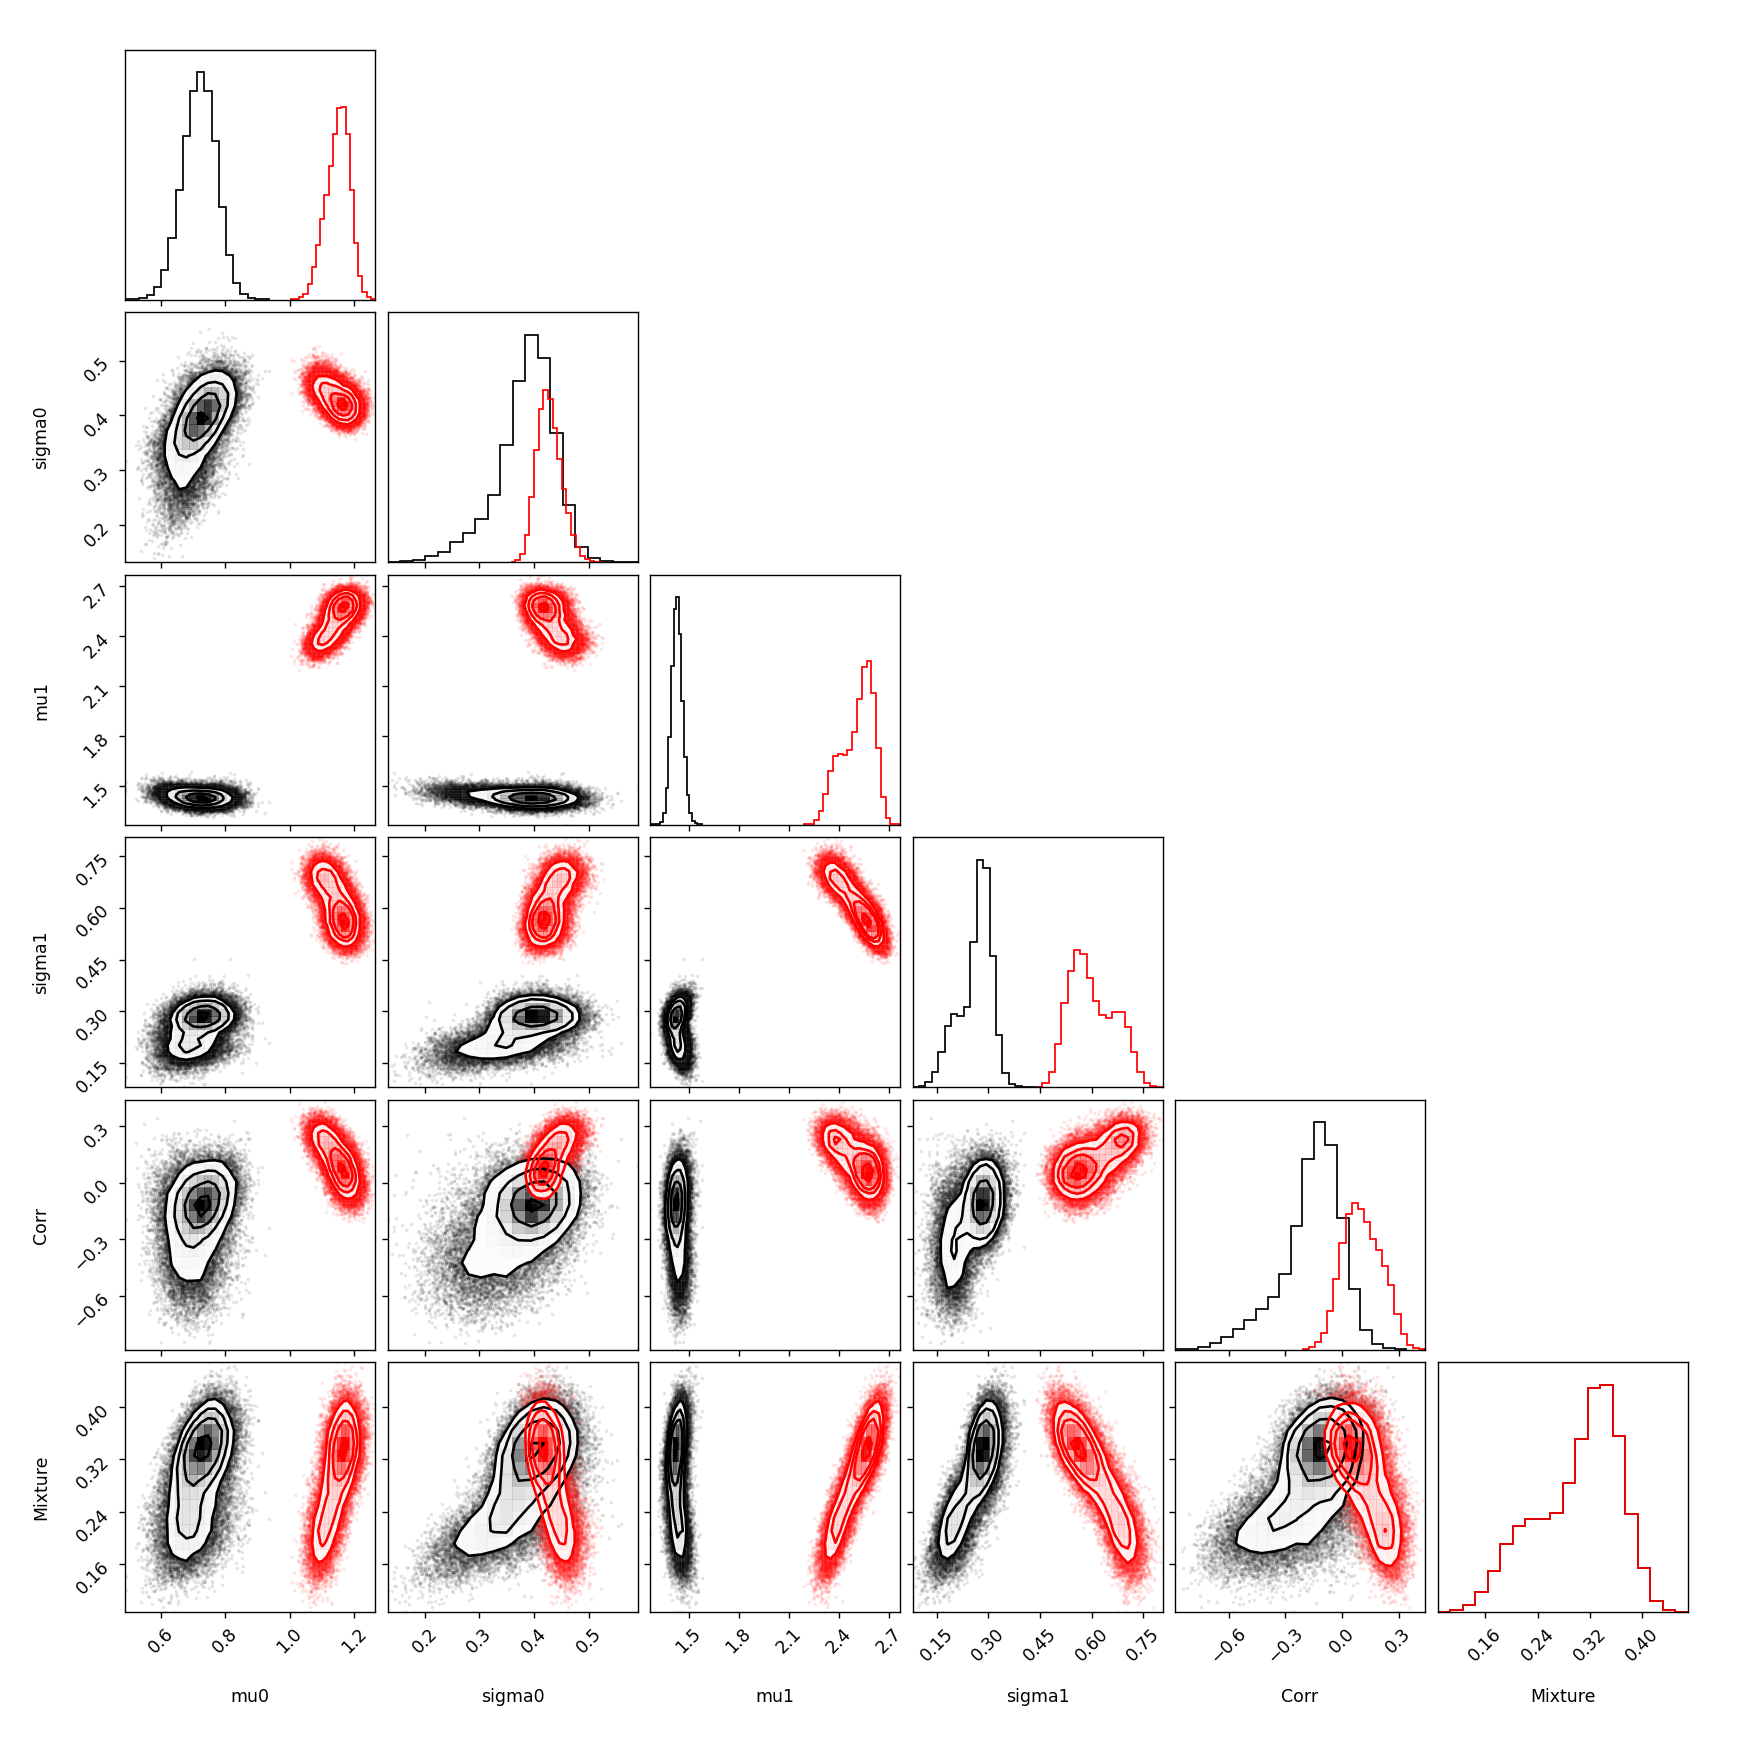

In [10]:
fig = corner.corner(numpyro_samples0, 
              labels=['mu0', 'sigma0', 'mu1', 'sigma1', 'Corr', 'Mixture']);

corner.corner(numpyro_samples1, fig=fig, color='r');